# Feature selection based on Aris' methods

After removing features based on variance and joining correlated features, the final step of feature selection is to apply classical methods of feature selection. This will be done based on Aris' script.

## Load input files

- Input dataframe containing original features and target variable
- Importance scores of different methods

In [2]:
#Turn off scientific notation
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

#Activate print all activities
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Input dataframe containing original features and target variable

In [2]:
import sys
import pickle
import zstandard
import pandas as pd
import numpy as np
import datetime

#Load original dataframe
path = '../join_highly_correlated/chosen_files/'

#folder = 'df_salt_kmer9Classification'
#file = path + folder + '_0.9000000000000001.pickle.zst'

#folder = 'df_salt_kmer9Regression'
#file = path + folder + '_0.9500000000000002.pickle.zst'

#folder = 'df_salt_gene-familiesRegression'
#file = path + folder + '_0.9000000000000001.pickle.zst'

folder = 'df_salt_gene-familiesClassification'
file = path + folder + '_0.7.pickle.zst'

#Define target group:
group = 'Salinity group'
#group = 'Salt all mean'
#group = 'Temp group'
#group = 'Temp all mean'
#group = 'pH all mean'
#group = 'Oxygen tolerance'

with zstandard.open(file, 'rb') as f:
	df = pickle.load(f)

df.head()

,COG3696@2,COG0606@2,CorGroup_COG1983@2,CorGroup_COG4771@2,CorGroup_COG0465@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG07581@2157,CorGroup_arCOG02142@2157,arCOG00996@1,CorGroup_arCOG07561@1,arCOG01620@2157,CorGroup_arCOG02620@2157,CorGroup_arCOG07873@1,arCOG06281@1,arCOG07786@1,Salinity group
Best assembly,,,,,,,,,,,,,,,,,,,,,
1123508.3,1,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1572859.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200615.4,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2541725.3,1,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2724192.3,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Importance scores of different methods

In [57]:
#method = 'tree-based'
method = 'L2'

#Load importance scores
#folder2 = '../feature_selection/' + 'df_salt_kmer9Classification' + '/' 

folder2 = '../feature_selection/' + folder + '/'
file2 = folder2 + 'Importance_scores_' + method + '_abiotic_factors.tsv'

df_scores = pd.read_csv(file2, sep = '\t')
df_scores = df_scores.sort_values(by='Importance_score', ascending=False)

print('Read file:', file2)

df_scores.head()

Read file: ../feature_selection/df_salt_gene-familiesClassification/Importance_scores_L2_abiotic_factors.tsv


,Feature,Importance_score
3001,COG3182@1,3001
3000,COG3004@2,3000
2999,COG0784@2,2999
2998,COG5276@2,2998
2997,COG1674@1,2997


# Save files with different number of features: DIFFERENT SELECTION METHODS

In [58]:
print('Producing files with different number of features for method: ', method, 'and file', file2)

#Loop to get the top scored features from 50 to 300
for i in range(50, 301, 50):  
    
    #Get the top 'i' rows
    top_feat = df_scores.head(i)['Feature'].tolist()
    
    #Get a subset of a dataframe with columns matchin ids from top_feat
    df_subset = df[top_feat]

    #Add the target column of df to df_subset
    last_col = df.iloc[:, -1]
    df_subset = pd.concat([df_subset, last_col], axis=1)
    
    #df_subset.head()
    df_subset.shape

    print(' Saved', folder2 + 'df_' + method + str(i) + '.csv')
    df_subset.to_csv(folder2 + 'df_' + method + str(i) + '.csv', index=True) 

Producing files with different number of features for method:  L2 and file ../feature_selection/df_salt_gene-familiesClassification/Importance_scores_L2_abiotic_factors.tsv


(932, 51)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_L250.csv


(932, 101)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_L2100.csv


(932, 151)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_L2150.csv


(932, 201)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_L2200.csv


(932, 251)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_L2250.csv


(932, 301)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_L2300.csv


# Save files with different number of features: RANDOM SET/negative control

In [3]:
method = 'random'

folder2 = '../feature_selection/' + folder + '/'

print('Producing files with different number of features for method: ', method)

#Separar as features (X) e o grupos (y)
X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 

#Loop to get the top scored features from 50 to 300
for i in range(50, 301, 50):  
        
    #Get a subset of dataframe X with i number of columns 
    df_subset = X.sample(n=i, axis=1)  # axis=1 is for columns

    #Add the target column of df to df_subset
    df_subset = pd.concat([df_subset, y], axis=1)
    
    #df_subset.head()
    df_subset.shape

    print(' Saved', folder2 + 'df_' + method + str(i) + '.csv')
    df_subset.to_csv(folder2 + 'df_' + method + str(i) + '.csv', index=True) 

Producing files with different number of features for method:  random


(932, 51)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_random50.csv


(932, 101)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_random100.csv


(932, 151)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_random150.csv


(932, 201)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_random200.csv


(932, 251)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_random250.csv


(932, 301)

 Saved ../feature_selection/df_salt_gene-familiesClassification/df_random300.csv


# Benchmark

In [5]:
#Importing packages
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

## Classification

In [6]:
#CLASSIFICATION #########################################

#Based on: Benchmark of "remove_zero-variance.ipynb"

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

n_jobs = 5
f1_df = pd.DataFrame()

print("Started script on: ", datetime.datetime.now())
print('Method: ', method)
print('Opening files named:', folder2 + 'df_' + method + 'i' + '.csv')

#Loop for different number of features
#for i in range(0, 301, 50):  
for i in range(50, 301, 50):      

    if(i == 0):
        i = 'no filter'
        tmp = df
    else:
        tmp = pd.read_csv(folder2 + 'df_' + method + str(i) + '.csv', index_col = 0) 
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')
    print('  Shape of input data:', tmp.shape)
    
    list_means = []

    #Separating features from group/target variable
    X = tmp.drop(group, axis=1)
    y = tmp[group]

    #I included random_state to make this command reproducible
    #Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle=True, random_state = 99)
    
    #UNDERSAMPLING has already been done in the variance filtering!
    
    print('  Shape of training data:', X.shape)
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):
#    for it in range(1, 3, 1):        

        #Cross-validation with seed that changes with every iteration. The same split is desired per thresholds, since I want to
        # compare them. However within iterations, I want different splits
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        #I ran salt, gene-families without seed, and the results were extremely similar
    
        #Instantiate Random Forest model
        clf = RandomForestClassifier()

        scoring = ['f1']
        output = cross_validate(clf, X, y, cv=5, scoring = scoring, return_train_score=False, return_estimator =True, n_jobs=n_jobs)
        #print(output)
        #{'fit_time': array([0.68, 0.73, 0.72, 0.68, 0.61]), 'score_time': array([0.12, 0.11, 0.11, 0.19, 0.11]), 
        #'estimator': [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()], 
        #'test_f1': array([0.91, 0.90, 0.88, 0.75, 0.68])}
        
        #Get mean F1 for this iteration
        mean = statistics.mean(output['test_f1'])
        #Add mean F1 to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean F1 value =', round(mean, 3), 'All values:', output['test_f1'])
    
    print(' Mean F1 score of cross-validation for all iterations:', round(statistics.mean(list_means), 3))
    print("Finished 10 iterations on: ", datetime.datetime.now())
    
    #Add new values
    f1_df[i] = list_means

Started script on:  2024-10-30 15:39:17.288737
Method:  random
Opening files named: ../feature_selection/df_salt_gene-familiesClassification/df_randomi.csv
Calculating metrics for threshold 50 of filtering low-variance features...
  Shape of input data: (932, 51)
  Shape of training data: (745, 50)
 Iteration 1 has as mean F1 value = 0.663 All values: [0.62 0.66 0.67 0.68 0.69]
 Iteration 2 has as mean F1 value = 0.666 All values: [0.61 0.69 0.65 0.69 0.69]
 Iteration 3 has as mean F1 value = 0.665 All values: [0.60 0.65 0.68 0.69 0.70]
 Iteration 4 has as mean F1 value = 0.666 All values: [0.61 0.68 0.68 0.69 0.67]
 Iteration 5 has as mean F1 value = 0.657 All values: [0.62 0.68 0.63 0.67 0.69]
 Iteration 6 has as mean F1 value = 0.663 All values: [0.61 0.68 0.64 0.71 0.67]
 Iteration 7 has as mean F1 value = 0.663 All values: [0.62 0.69 0.65 0.67 0.68]
 Iteration 8 has as mean F1 value = 0.655 All values: [0.59 0.68 0.64 0.68 0.69]
 Iteration 9 has as mean F1 value = 0.667 All values

## Regression

In [28]:
#REGRESSION #########################################

#Based on: Benchmark of "remove_zero-variance.ipynb/py"

#Importing packages
import pickle
import zstandard
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from sklearn.ensemble import RandomForestRegressor


#REGRESSION #########################################

#For different scoring of cross_validate, check: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter "Regression"
#For the output of cross_validate: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

n_jobs = 5
f1_df = pd.DataFrame()

print("Started script on: ", datetime.datetime.now())
print('Method: ', method)
print('Opening files named:', folder2 + 'df_' + method + 'i' + '.csv')

#Loop for different number of features
#for i in range(0, 301, 50):  
for i in range(50, 301, 50):      

    if(i == 0):
        i = 'no filter'
        tmp = df
    else:
        tmp = pd.read_csv(folder2 + 'df_' + method + str(i) + '.csv', index_col = 0) 
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')
    print('  Shape of input data:', tmp.shape)
    
    list_means = []

    #Separating features from group/target variable
    X = tmp.drop(group, axis=1)
    y = tmp[group]

    #I included random_state to make this command reproducible for after feature selection
    #Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 99)

    print('  Shape of training data:', X_train.shape)
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):   

        #Cross-validation
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        #Instantiate Random Forest model
        clf = RandomForestRegressor()

        scoring = 'neg_mean_absolute_error'
        output = cross_validate(clf, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, return_estimator=True, n_jobs=15)
        #print(output)
        #{'fit_time': array([57.96, 62.67, 56.21, 67.85, 60.65]), 'score_time': array([0.05, 0.05, 0.05, 0.05, 0.05]), 
        #'estimator': [RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor()], 
        #'test_score': array([-13.17, -12.15, -17.07, -19.26, -32.13])}

        #Get mean MAE for this iteration
        mean = statistics.mean(output['test_score'])
        #Add mean MAE to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean absolute error =', round(mean, 3), 'All errors:', output['test_score'])
    
    print(' Mean absolute error of cross-validation for all iterations:', round(statistics.mean(list_means), 3))

    #Add new values
    f1_df[i] = list_means
    
    #Save benchmark results to a CSV file
#    f1_df.to_csv(path + 'mae_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

#Save benchmark results to a CSV file
#f1_df.to_csv(path + 'mae_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

Started script on:  2024-10-30 15:35:21.821287
Method:  random
Opening files named: ../feature_selection/df_salt_gene-familiesRegression/df_randomi.csv
Calculating metrics for threshold 50 of filtering low-variance features...
  Shape of input data: (3418, 51)
  Shape of training data: (2734, 50)


/home/bia/.local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Iteration 1 has as mean absolute error = -24.382 All errors: [-23.82 -23.05 -23.58 -26.49 -24.98]
 Iteration 2 has as mean absolute error = -24.349 All errors: [-23.79 -22.97 -23.57 -26.50 -24.91]
 Iteration 3 has as mean absolute error = -24.373 All errors: [-23.84 -23.05 -23.57 -26.50 -24.90]
 Iteration 4 has as mean absolute error = -24.348 All errors: [-23.78 -22.97 -23.56 -26.50 -24.92]
 Iteration 5 has as mean absolute error = -24.358 All errors: [-23.80 -23.02 -23.55 -26.56 -24.87]
 Iteration 6 has as mean absolute error = -24.352 All errors: [-23.82 -22.95 -23.59 -26.51 -24.89]
 Iteration 7 has as mean absolute error = -24.377 All errors: [-23.81 -23.02 -23.60 -26.56 -24.90]
 Iteration 8 has as mean absolute error = -24.373 All errors: [-23.82 -23.07 -23.58 -26.52 -24.87]
 Iteration 9 has as mean absolute error = -24.372 All errors: [-23.84 -23.01 -23.57 -26.51 -24.93]
 Iteration 10 has as mean absolute error = -24.369 All errors: [-23.79 -23.01 -23.61 -26.48 -24.96]
 Mean abs

## Save metrics

In [7]:
#file_out_filtered

print('Method: ', method)
print('Saved file:', folder2 + 'df_' + method + '_F1/MAE_benchmarking.csv')

#Save benchmark results to a CSV file
f1_df.to_csv(folder2 + 'df_' + method + '_F1_benchmarking.csv', index=True)
#f1_df.to_csv(folder2 + 'df_' + method + '_MAE_benchmarking.csv', index=True)

Method:  random
Saved file: ../feature_selection/df_salt_gene-familiesClassification/df_random_F1/MAE_benchmarking.csv
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Plot

In [8]:
#method = 'tree-based'
#method = 'L2'

In [9]:
import pandas as pd

print('Method: ', method)

file_plot = folder2 + 'df_' + method

#Classification:
file_metrics = file_plot + '_F1_benchmarking.csv'
#Regression:
#file_metrics = file_plot + '_MAE_benchmarking.csv'

figure = folder2 + method + '.png'

# Load CSV data into a DataFrame
print('Loaded file', file_metrics)
f1_df = pd.read_csv(file_metrics, index_col = 0)

f1_df.head()

Method:  random
Loaded file ../feature_selection/df_salt_gene-familiesClassification/df_random_F1_benchmarking.csv


,50,100,150,200,250,300
0,0.66,0.76,0.75,0.79,0.83,0.81
1,0.67,0.76,0.74,0.77,0.82,0.80
2,0.67,0.76,0.74,0.78,0.82,0.81
3,0.67,0.76,0.74,0.78,0.83,0.80
4,0.66,0.75,0.74,0.78,0.83,0.80


../feature_selection/df_salt_gene-familiesClassification/random.png


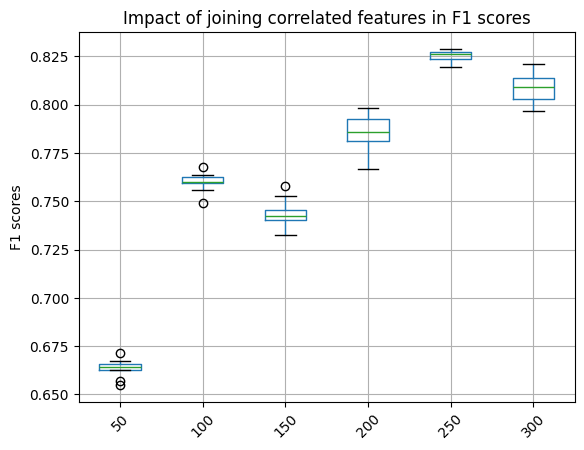

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

#Plot results 

#ADAPT THE LABELS FOR REGRESSION/CLASSIFICATION
#Plot the metrics for the cross-validation

boxplot = f1_df.boxplot();

#Add axis labels and title
plt.ylabel('F1 scores');
#plt.ylabel('Mean Absolute Error (MAE)');
plt.title('Impact of joining correlated features in F1 scores');
#plt.title('Impact of joining correlated features in MAEs');

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
ticks = plt.xticks()[0]
labels = [str(round(float(label), 1)) for label in ticks]  # Round each label to 3 decimal places

plt.savefig(figure, dpi=300, bbox_inches='tight')
print(figure)

#Show plot
plt.show();

# Filter files

See [wiki](https://git.bia-christian.de/bia/lab_book_VEO/wiki/feature-selection) for details. After analysing the plots produced by RFE, tree-based and L2, we saw that RFE shows clear elbow points for all datasets, making the decision clear on how many features we should choose for the next step of the project.   

This block of code filters datasets based on results of the RFE feature selection calculation. All features with score = 1 are kept. This comprises most of the features.

In [46]:
import sys
import pandas as pd
import numpy as np

#Load input dataframe from joining features by correlation

#feature = 'gene-familiesClassification'
feature = 'gene-familiesRegression'
#feature = 'kmer9Classification'
#feature = 'kmer9Regression'
#feature = 'gene-families'
#feature = 'kmer9'

#abiotic_factor = 'salt'
abiotic_factor = 'temperature'
#abiotic_factor = 'pH'
#abiotic_factor = 'oxygen'

#var_filter = '0.7'                                 #salt Class GF
#var_filter = '0.9000000000000001'                  #salt Reg GF
#var_filter = '0.9000000000000001'                  #salt Class kmer9
var_filter = '0.9500000000000002'                  #salt Reg kmer9
#var_filter = ''                 #temp Class GF
#var_filter = ''                                #temp Reg GF
#var_filter = ''                               #temp Reg kmer9
#var_filter = ''                   #temp Class kmer9
#var_filter = ''                  #oxygen Class GF
#var_filter = ''                 #oxygen Class kmer9
#var_filter = ''                               #pH Reg kmer9  
#var_filter = ''                                 #pH Reg GF  

#Define target group:
#group = 'Salinity group'
#group = 'Salt all mean'
#group = 'Temp group'
#group = 'Temp all mean'
#group = 'pH all mean'
#group = 'Oxygen tolerance'

#Input
path = '/home/bia/Documents/BacterialData/run_features/join_highly_correlated/chosen_files/'

file = path + 'df_' + abiotic_factor + '_' + feature + '_' + var_filter + '.csv'  
file

output_folder = '/home/bia/Documents/BacterialData/run_features/feature_selection/chosen_files/'
output_file = output_folder + 'df_' +  abiotic_factor + '_' + feature + '_filtered.csv' 

df = pd.read_csv(file)
# Set the 'Feature' column as the index
df.set_index('Best assembly', inplace=True)
    
df.head()
df.shape

'/home/bia/Documents/BacterialData/run_features/join_highly_correlated/chosen_files/df_temperature_gene-familiesRegression_0.9500000000000002.csv'

/tmp/ipykernel_22690/3064813423.py:49: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,2Z7XP@2,COG1086@2,COG2244@2,...,arCOG00643@2157,arCOG00282@2157,arCOG05967@2157,arCOG01496@2157,arCOG02623@2157,arCOG03384@2157,arCOG03665@2157,arCOG00257@2157,arCOG03696@2157,Temp all mean
Best assembly,,,,,,,,,,,,,,,,,,,,,
1002367.30,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,37.00
101383.40,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.00
1049789.40,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30.00
1056810.30,1,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,30.00
108980.91,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29.00


(13198, 5582)

In [47]:
#Load input file with RFE's list of importance scores

#Input2
path2 = '/home/bia/Documents/BacterialData/run_features/feature_selection/'
file2 = path2 + 'df_' + abiotic_factor + '_' + feature + '/Importance_scores_RFE_Salt_Bia.tsv'

file2

df_scores = pd.read_csv(file2, sep = '\t')
# Set the 'Feature' column as the index
df_scores.set_index('Feature', inplace=True)

df_scores.head()
df_scores.shape

'/home/bia/Documents/BacterialData/run_features/feature_selection/df_temperature_gene-familiesRegression/Importance_scores_RFE_Salt_Bia.tsv'

,Importance_score
Feature,
CorGroup_arCOG04754@2157,0.00
2ZAVI@2,0.00
COG0587@2,0.00
COG1993@1,0.00
COG1236@2,0.00


(5581, 1)

In [48]:
# Filter df2 for features with Importance_score == 1
important_features = df_scores[df_scores['Importance_score'] == 1].index

# Select the corresponding columns in df1 based on these features
df_filtered = df[important_features]

# Get the last column of df1
last_col = df.iloc[:, -1]

# Add the last column to df_filtered (use concat to combine along columns)
df_filtered = pd.concat([df_filtered, last_col], axis=1)

df_filtered.head()
df_filtered.shape

,COG0593@2,COG0402@2,Temp all mean
Best assembly,,,
1002367.30,1,0,37.00
101383.40,0,0,10.00
1049789.40,0,0,30.00
1056810.30,0,1,30.00
108980.91,1,1,29.00


(13198, 3)

In [39]:
output_file

# Save the DataFrame to a CSV file, keeping the index
df_filtered.to_csv(output_file, index=True)

'/home/bia/Documents/BacterialData/run_features/feature_selection/chosen_files/df_salt_kmer9Classification_filtered.csv'